In [1]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.resnet import preprocess_input

In [2]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = preprocess_input(img)

    return img, image_path


In [3]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [4]:
with open("../dataset/captions.json") as jf:
    captions = json.loads(jf.read())

#Extract lstm from captions data set.
lstm_info = captions.pop("lstm_labels")
lstm_ranker = lstm_info['labels']
max_vocab_size = lstm_info['vocab_size']
max_caption_size = lstm_info['longest_caption']

#Dataset cleanup
img_name_vector = []
edited_captions = []

image_paths = list(captions.keys())
random.shuffle(image_paths)

for image_path in image_paths:
    captions_image = captions[image_path]
    captions_len = len(captions_image)
    
    for c in captions_image:
        caption = f"<start> {c} <end>"
        edited_captions.append(caption)
    
    img_name_vector.extend([f"{image_path}.jpg"] * captions_len)

train_set_size = round(len(img_name_vector) * 0.9)
test_set_size = len(img_name_vector) - train_set_size

while(img_name_vector[train_set_size] != img_name_vector[train_set_size + 1]):
    train_set_size += 1
    test_set_size -= 1

print(f"TRAIN SET SIZE: {train_set_size}.")
print(f"TEST SET SIZE: {test_set_size}.")

train_captions = edited_captions[:train_set_size]
train_image_name = img_name_vector[:train_set_size]
test_captions = edited_captions[train_set_size:]
test_image_name = img_name_vector[train_set_size:]
for i in range(len(img_name_vector)):
    img_name_vector[i] = f"../dataset/prep_data/{img_name_vector[i]}"

TRAIN SET SIZE: 48917.
TEST SET SIZE: 5435.


<start> She is wearing lipstick. <end>


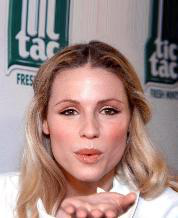

In [5]:
print(train_captions[3])
Image.open(f"../dataset/prep_data/{train_image_name[3]}")

In [38]:

encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    print(batch_features.shape[0])
    print(batch_features.shape[3])
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    
    # for bf, p in zip(batch_features, path):
    #     path_of_feature = p.numpy().decode("utf-8")
    #     np.save(path_of_feature, bf.numpy())

1it [00:02,  2.03s/it]16
2048
2it [00:03,  1.97s/it]16
2048
3it [00:05,  1.93s/it]16
2048
4it [00:07,  1.94s/it]16
2048
4it [00:09,  2.27s/it]


KeyboardInterrupt: 

16


IndexError: list index out of range

In [6]:
train_set_size = 15000
test_set_size = 2000

while train_image_name[train_set_size] == train_image_name[train_set_size + 1]:
    train_set_size += 1

train_images = train_image_name[:train_set_size]
temp = train_captions[:train_set_size]

index_end = train_set_size + test_set_size

while train_image_name[index_end] == train_image_name[index_end+1]:
    index_end +=1
    
test_images = train_image_name[train_set_size:index_end]
test_captions = train_captions[train_set_size:index_end]
train_captions = temp

In [7]:
print(len(test_images))
print(len(test_captions))
print(len(train_images))
print(len(train_captions))

2000
2000
15006
15006


In [8]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
top_v = 45

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_v,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [10]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [11]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [13]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [14]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [15]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)
    

(11945, 11945, 3061, 3061)

In [16]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_v + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [17]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')[:-4]+'.npy')
  return img_tensor, cap

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
from gru_decoder import GRU_Decoder
from cnn_encoder import CNN_Encoder
from gru_encoder import GRU_Encoder

In [20]:
decoder = GRU_Decoder(embedding_dim, units, vocab_size)
encoder = CNN_Encoder(embedding_dim)
enc = GRU_Encoder(embedding_dim, units, vocab_size)

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [22]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [23]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [24]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [39]:
import sys
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden_e = enc.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  m=dec_input
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      # print(features.shape)
      # print(features)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          with tape.stop_recording():
            pred_prob = tf.nn.softmax(predictions)
          print(features.shape)
          # print("predictions")
          # print(predictions.shape)
          # k=tf.random.categorical(predictions, 1)[0][0].numpy()
          # print(tf.random.categorical(predictions, 1)[0].numpy())
          # print("S")
          print("Predictions Sire")
          print(predictions.shape)
          print(target.shape)
          print(target[:,i].shape)
          loss += loss_function(target[:, i], predictions)

          v, _ = enc(dec_input, hidden_e)
          print(v)
          print("Now")
          print(v.shape)  
          print("After")
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
  print(m.shape)
  print(pred_prob)  
  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, trainable_variables)
  print(len(gradients))
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [40]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, 'she': 4, 'has': 5, 'is': 6, 'he': 7, 'hair': 8, 'a': 9, 'wearing': 10, 'younger': 11, 'nose': 12, 'smiling': 13, 'big': 14, 'lipstick': 15, 'wavy': 16, 'an': 17, 'oval': 18, 'face': 19, 'older': 20, 'pointy': 21, 'black': 22, 'lips': 23, 'brown': 24, 'straight': 25, 'earings': 26, 'beard': 27, 'blond': 28, 'bangs': 29, 'necklace': 30, 'eyeglasses': 31, 'necktie': 32, 'receding': 33, 'hairline': 34, 'chubby': 35, 'goatee': 36, 'gray': 37, 'sideburns': 38, 'hat': 39, 'rosy': 40, 'cheeks': 41, 'double': 42, 'chin': 43, 'pale': 44, 'skin': 45, 'mustache': 46, 'bald': 47, '<pad>': 0}


In [42]:
EPOCHS = 1

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        features = encoder(img_tensor)
        print(features)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        break
    #     if batch % 100 == 0:
    #         print ('Epoch {} Batch {} Loss {:.4f}'.format(
    #           epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # # storing the epoch end loss value to plot later
    # loss_plot.append(total_loss / num_steps)

    # if epoch % 5 == 0:
    #   ckpt_manager.save()

    # print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
    #                                      total_loss/num_steps))
    # print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

tf.Tensor(
[[[0.         0.28334388 0.2857422  ... 0.         0.02147567 0.        ]
  [0.         0.16054794 0.29225042 ... 0.         0.         0.        ]
  [0.         0.         0.62407804 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.17783883 0.04697162]
  [0.         0.         0.         ... 0.         1.3118887  0.        ]
  [0.         0.         0.         ... 0.         1.3359143  0.        ]]

 [[0.         0.28334388 0.2857422  ... 0.         0.02147567 0.        ]
  [0.         0.16054794 0.29225042 ... 0.         0.         0.        ]
  [0.         0.         0.62407804 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.17783883 0.04697162]
  [0.         0.         0.         ... 0.         1.3118887  0.        ]
  [0.         0.         0.         ... 0.         1.3359143  0.        ]]

 [[0.         0.         0.07354311 ... 0.         0.         0.09945904]
  [0.      

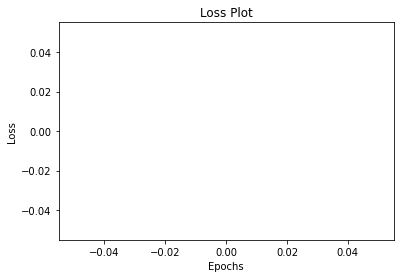

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [380]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [381]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()



[[9.7543784e-10 1.0184886e-08 8.8038454e-10 7.8494800e-08 6.0961801e-01
  7.8525462e-09 1.1145849e-08 3.9038107e-01 1.8673298e-08 2.2875426e-08
  2.0109125e-07 5.9627489e-08 5.6680424e-08 3.1123631e-10 2.2090774e-09
  6.3022050e-09 7.7080529e-08 3.0752949e-09 3.5461079e-10 7.2623902e-09
  2.0511197e-07 3.0389216e-09 9.5800488e-09 3.5424014e-11 1.7913120e-08
  1.2521979e-09 5.4182903e-09 4.4492751e-10 6.6303141e-09 4.1599076e-08
  9.2548023e-09 2.6312621e-09 1.1093986e-09 5.1387061e-10 1.3512406e-08
  3.7551324e-08 1.9823213e-08 1.5114353e-10 9.7891055e-09 9.2211558e-11
  5.8469811e-09 5.1704054e-09 1.1605703e-09 4.8317546e-09 8.9447756e-09
  7.6213458e-10]]
4
0.609618
4
0.609618
[[8.4895089e-07 1.1821272e-07 6.1073973e-07 5.4004973e-05 3.7895830e-04
  3.9744818e-01 6.0144383e-01 7.9716352e-05 4.8462148e-08 3.9849515e-04
  1.7677498e-06 1.8930511e-06 6.9271977e-07 4.7098536e-07 1.2659632e-07
  4.5737429e-06 1.1230261e-07 4.8006732e-05 1.1514865e-06 4.1274202e-08
  2.8312104e-06 9.214339

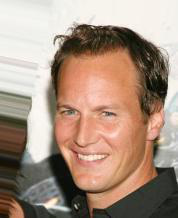

In [382]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[768]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[768]}")

[[6.7744976e-11 9.4086761e-10 4.5505173e-11 8.1067837e-09 9.9956626e-01
  5.2983645e-10 6.6196154e-10 4.3367362e-04 4.8661648e-09 3.7568113e-09
  5.2449662e-09 1.4704254e-09 1.0885025e-09 1.5608697e-11 7.2368139e-10
  4.3480801e-09 2.5193094e-09 9.8002284e-10 3.2879272e-11 1.2119798e-09
  3.6264840e-09 3.9933958e-09 1.2906283e-09 1.6470479e-11 1.2049268e-09
  3.5228653e-11 1.5213206e-09 2.1689756e-11 5.9742822e-10 2.8399252e-09
  4.0611497e-10 1.2031149e-09 1.9708833e-10 1.8404521e-11 1.1970490e-09
  3.6043346e-09 4.2497232e-09 7.0075877e-12 1.5876050e-10 1.8817305e-11
  1.5122244e-10 7.2979145e-10 3.6273606e-10 5.2254617e-10 1.0788787e-09
  2.8589551e-11]]
4
0.99956626
4
0.99956626
[[6.6098471e-07 9.4435002e-08 5.5776229e-07 7.0616908e-05 1.8801361e-03
  4.4666755e-01 5.5014032e-01 9.3649231e-07 1.2800179e-07 7.1701058e-04
  3.8846650e-07 6.0496899e-07 1.8567489e-07 1.8457517e-07 3.6788882e-07
  1.4981892e-05 9.2433936e-08 8.3990912e-05 1.3369881e-06 1.3798791e-07
  6.9076719e-07 4.08

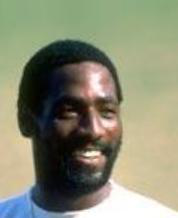

In [390]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[51]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[51]}")

[[5.9574568e-10 1.9336587e-08 4.5364926e-10 7.8868474e-08 9.9581438e-01
  4.7578981e-09 6.0578587e-09 4.1847192e-03 3.5634820e-08 3.3637619e-08
  1.4609245e-07 3.7051809e-08 3.2864360e-08 2.5191035e-10 3.3890757e-09
  4.5275502e-08 5.1120718e-08 7.2238042e-09 2.0286668e-10 2.9475649e-09
  7.5336537e-08 5.9903698e-08 9.3353263e-09 1.1197339e-10 6.6401729e-09
  2.2666147e-10 1.6783487e-08 6.2824107e-10 1.1911737e-09 1.2367558e-08
  4.5842912e-09 2.4870758e-08 6.5369243e-10 6.3483448e-11 3.5201042e-09
  4.0572935e-08 2.1218177e-08 3.0460809e-10 2.5763311e-09 5.9809421e-11
  1.3863978e-09 3.4202201e-09 1.9844955e-09 3.2313032e-08 3.3287273e-09
  2.4998190e-10]]
4
0.9958144
4
0.9958144
[[8.7291636e-07 9.7602928e-08 6.7523712e-07 6.4456653e-05 2.1565962e-03
  4.4090095e-01 5.5589390e-01 2.2768911e-05 5.4112263e-08 7.1539113e-04
  1.0802572e-06 1.0721839e-06 4.3112672e-07 3.4318376e-07 8.1682302e-08
  8.3183959e-06 7.9538886e-08 8.4933774e-05 1.3930299e-06 5.4964509e-08
  2.7350259e-06 1.1975

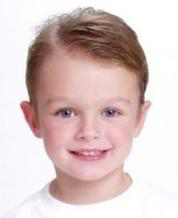

In [384]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[3]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[3]}")

[[3.3383730e-11 2.4219676e-10 1.5791510e-11 5.3676672e-09 9.9999523e-01
  3.9276440e-10 3.8256262e-10 4.7660756e-06 7.0930922e-10 5.0910569e-09
  8.7122185e-09 4.0074886e-09 1.5779994e-09 7.9250512e-12 1.0936358e-10
  3.2907532e-09 7.0333173e-10 1.1193363e-09 8.3340262e-12 2.8681160e-10
  1.7128532e-09 1.4427393e-08 1.1497682e-10 1.7159841e-11 1.5460200e-10
  1.6712597e-11 5.7151900e-10 7.3463961e-12 1.7596530e-10 6.6278777e-10
  1.7581533e-10 9.9522790e-10 2.7200792e-11 1.0053746e-12 8.2252705e-11
  1.2586356e-09 5.0272814e-10 1.2457177e-12 2.5516497e-11 1.6536825e-12
  1.8051264e-11 1.9206760e-10 1.2761023e-10 9.3246140e-11 1.3500324e-10
  9.9606825e-12]]
4
0.99999523
4
0.99999523
[[3.1378727e-07 3.6630581e-08 2.5058731e-07 3.1011648e-05 3.3489498e-04
  4.4330603e-01 5.5595183e-01 5.0754147e-06 2.6189182e-08 2.6734528e-04
  3.0759955e-07 3.8249416e-07 1.5733602e-07 1.5145208e-07 3.7020612e-08
  3.7199197e-06 4.1700236e-08 2.6466616e-05 9.0431473e-07 3.6125595e-08
  8.8839818e-07 4.63

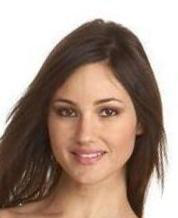

In [385]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[1000]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[1000]}")

[[7.4742146e-10 8.8071843e-09 6.7456835e-10 1.6384580e-07 9.6762532e-01
  5.0873585e-09 7.7295734e-09 3.2373961e-02 5.5558328e-08 1.0253936e-08
  8.9205450e-08 4.7100773e-08 2.8407609e-08 1.8253052e-10 6.8080017e-09
  2.5599700e-08 8.5100964e-08 1.3695757e-09 3.4397374e-10 1.0974839e-08
  1.9396191e-08 2.2108766e-08 3.1359306e-08 4.9000807e-11 7.3345106e-08
  6.3334432e-10 8.1472562e-09 5.3324700e-10 1.5397974e-08 7.3206458e-08
  8.5778842e-09 4.1216999e-09 1.8783544e-09 3.7151449e-10 1.4164082e-08
  1.4679377e-08 1.6257392e-08 1.8677501e-10 3.7018701e-09 1.4028963e-10
  2.4528097e-09 5.5091989e-09 3.0246763e-09 4.3247477e-09 2.1993692e-08
  4.0023837e-10]]
4
0.9676253
4
0.9676253
[[7.2372382e-07 1.4637375e-07 6.3482554e-07 1.0503832e-04 6.9645955e-04
  3.6414421e-01 6.3442379e-01 5.1915038e-05 1.3379874e-07 2.9186998e-04
  1.1487699e-06 2.3525504e-06 7.0486306e-07 2.2599747e-07 6.0334997e-07
  6.8016520e-06 3.0774339e-07 2.5074660e-05 6.5994544e-07 8.8130619e-08
  7.1057434e-07 5.7041

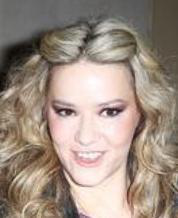

In [386]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[876]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[876]}")

[[2.64018446e-10 1.13928511e-09 2.57720040e-10 2.79601764e-08
  9.94742036e-01 2.16063101e-09 2.81134227e-09 5.25785331e-03
  4.71597650e-09 3.37094153e-09 3.86271992e-08 1.78036483e-08
  8.67991723e-09 5.08779546e-11 3.78222870e-10 6.45532694e-09
  5.26544897e-09 7.67074182e-10 1.34032771e-10 1.41588496e-09
  2.31829382e-08 5.18383558e-09 2.50731302e-09 2.29258418e-11
  7.39136308e-09 9.35221414e-11 2.49653764e-09 2.97992499e-11
  1.25023880e-09 7.35540251e-09 1.84867444e-09 1.19314325e-09
  3.36399658e-10 6.66900493e-11 2.74254308e-09 7.19185600e-09
  5.93782401e-09 7.68699167e-12 5.45337386e-10 1.28184295e-11
  6.58744115e-10 9.94695770e-10 3.43649498e-10 4.78047379e-10
  1.66550640e-09 1.96278951e-10]]
4
0.99474204
4
0.99474204
[[9.4328755e-07 6.9357029e-08 8.0784599e-07 8.6163382e-05 1.5069309e-03
  4.2652586e-01 5.7099968e-01 8.6367108e-06 4.2476991e-08 5.4914464e-04
  1.3191478e-06 2.0877553e-06 5.5558780e-07 2.8222516e-07 8.3577696e-08
  8.4776793e-06 5.6022813e-08 5.9725593e-0

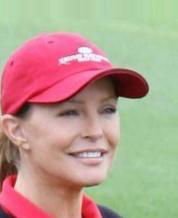

In [387]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[78]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[78]}")

[[2.6337016e-10 1.4399140e-09 1.2531294e-10 2.2523269e-08 9.9991238e-01
  4.2038373e-10 5.4091914e-10 8.7359156e-05 1.9528723e-09 4.3513948e-09
  7.8599996e-08 2.1823098e-08 1.3355468e-08 3.4110902e-11 1.7663061e-10
  1.6204101e-08 9.3686980e-10 1.8715400e-09 2.8483117e-11 2.4457475e-10
  1.6151427e-08 1.4227890e-08 7.3877088e-10 5.2180246e-11 1.5067591e-09
  1.1106807e-11 6.0679555e-09 1.7404408e-11 2.8106764e-10 2.2690994e-09
  2.2865996e-09 1.7249661e-09 1.5899036e-10 3.7686312e-11 3.0700487e-10
  1.7221264e-08 1.2198058e-09 3.9776728e-12 3.1674541e-10 9.6325127e-12
  5.8065559e-11 8.4730711e-10 2.0349726e-10 7.0805257e-11 7.9175444e-10
  1.5800362e-10]]
4
0.9999124
4
0.9999124
[[2.0768970e-05 5.5786122e-06 1.5403673e-05 3.0252757e-03 4.8779655e-01
  1.9989130e-01 2.9030821e-01 1.2813469e-04 4.5025490e-06 9.2498064e-03
  7.0378672e-05 7.3540032e-05 2.5847719e-05 2.5383374e-06 7.1794252e-06
  6.5929879e-04 2.7762055e-06 8.0619747e-04 5.9964837e-06 9.1207670e-07
  3.9847851e-05 3.1450

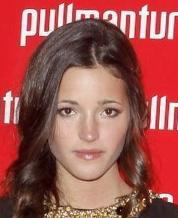

In [388]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[80]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[80]}")